In [1]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms
import torchvision.models as models

import seaborn as sns
from random import randint
from torch.nn import ReLU
import matplotlib.pyplot as plt
import numpy as np

C:\Users\delpi\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\delpi\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


> <span style="color:magenta">Base de données choisie : Brain Tumor Classification (MRI) https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri</span>
> <span style="color:magenta">Objectif : detection de différents type de cancer du cerveau à l'aide d'imagerie médicale</span>

# Prétraitement
## redimension des images de manière uniforme

> <span style="color:magenta">On donne aux images une taille uniforme pour les mettre dans uin data laoder
    
> <span style="color:magenta">Attention nous avons chosis d'harmoniser la taille des images en 100 par 100. Ce choix est bien évidament discutable puisque la qualité des images sont fotmeent réduit, toutefois, il s'agit pour nous d'un compromis par rapport au temps d'apprentissage</span>

In [2]:
from PIL import Image
import os

input_folder = r"C:\Users\delpi\Mon Drive\COURS\AgroParisTech\3A IODAA\PROG\archive"

if not os.path.exists('brainImage'):
    os.makedirs('brainImage')

for folder in os.listdir(input_folder):
    folder_path = os.path.join(input_folder, folder)
    if os.path.isdir(folder_path):
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            if os.path.isdir(subfolder_path):
                for filename in os.listdir(subfolder_path):
                    file_path = os.path.join(subfolder_path, filename)
                    if os.path.isfile(file_path):
                        img = Image.open(file_path)
                        img = img.resize((100, 100))
                        output_folder = os.path.join('brainImage', folder, subfolder)
                        os.makedirs(output_folder, exist_ok=True)
                        img.save(os.path.join(output_folder, filename))

## Augmentation des données

> <span style="color:magenta">On fait des rotation de 0, 90, 180 degré</span>

In [3]:
input_folder = r"C:\Users\delpi\Mon Drive\COURS\AgroParisTech\3A IODAA\PROG\archive"

if not os.path.exists('brainImageAugmented'):
    os.makedirs('brainImageAugmented')

for folder in os.listdir(input_folder):
    folder_path = os.path.join(input_folder, folder)
    for subfolder in os.listdir(folder_path):
        path = os.path.join(folder_path, subfolder)
        if not os.path.isdir(path):
            continue
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = Image.open(img_path)
            img = img.resize((100, 100))
            for angle in [0, 90, 180]:
                rotated = img.rotate(angle)
                rotated_path = os.path.join("brainImageAugmented", folder, subfolder)
                os.makedirs(rotated_path, exist_ok=True)
                rotated_file_name = f"{filename[:-4]}_{angle}.jpg"
                rotated.save(os.path.join(rotated_path, rotated_file_name))

# Extraction de données

In [4]:
train = torchvision.datasets.ImageFolder(root=r"C:\Users\delpi\Mon Drive\COURS\AgroParisTech\3A IODAA\PROG\brainImage\Training", transform=transforms.ToTensor())
valPart = int(len(train) * 0.2)
trainPart = len(train) - valPart

train, val = torch.utils.data.random_split(train, [trainPart, valPart])

trainLoader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
valLoader = torch.utils.data.DataLoader(val, batch_size=64, shuffle=True)

In [5]:
trainAugmented = torchvision.datasets.ImageFolder(root=r"C:\Users\delpi\Mon Drive\COURS\AgroParisTech\3A IODAA\PROG\brainImageAugmented\Training", transform=transforms.ToTensor())
valPartAugmented = int(len(trainAugmented) * 0.2)
trainPartAugmented = len(trainAugmented) - valPartAugmented

trainAugmented, valAugmented = torch.utils.data.random_split(trainAugmented, [trainPartAugmented, valPartAugmented])

trainLoaderAugmented = torch.utils.data.DataLoader(trainAugmented, batch_size=64, shuffle=True)
valLoaderAugmented = torch.utils.data.DataLoader(valAugmented, batch_size=64, shuffle=True)

In [6]:
test = torchvision.datasets.ImageFolder(root=r"C:\Users\delpi\Mon Drive\COURS\AgroParisTech\3A IODAA\PROG\brainImage\Testing", transform=transforms.ToTensor())
testLoader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True, num_workers=4)

In [7]:
testAugmented = torchvision.datasets.ImageFolder(root=r"C:\Users\delpi\Mon Drive\COURS\AgroParisTech\3A IODAA\PROG\brainImageAUgmented\Testing", transform=transforms.ToTensor())
testLoaderAugmented = torch.utils.data.DataLoader(testAugmented, batch_size=64, shuffle=True, num_workers=4)

In [8]:
numClasses = len(train.dataset.classes)
classCount = [0] * numClasses
for images, labels in trainLoader:
    for label in labels:
        classCount[label] += 1

classCount

[657, 657, 317, 665]

> <span style="color:magenta">Attention au déséquilibre des classes!!</span>

In [9]:
mod = models.resnet18(pretrained=True)
for name, param in mod.named_parameters():
    if 'fc' not in name:
        param.requires_grad = False
numFtrs = mod.fc.in_features
mod.fc = nn.Linear(numFtrs, len(classCount))

modAugmented = models.resnet18(pretrained=True)
for name, param in modAugmented.named_parameters():
    if 'fc' not in name:
        param.requires_grad = False
numFtrs = mod.fc.in_features
modAugmented.fc = nn.Linear(numFtrs, len(classCount))

C:\Users\delpi\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\delpi\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Entrainement des modèles

In [10]:
combo = ["normal", mod, trainLoader, valLoader, testLoader]
comboAugmented = ["augmented", modAugmented, trainLoaderAugmented, valLoaderAugmented, testLoaderAugmented]

comboList = [combo, comboAugmented]

In [11]:
def training(model, train, device, optimizer, criterion, scheduler):
    model.to(device)
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train:
        # Move inputs and labels to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        #gradient reset
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #saving the mean gradient to see how the model is learning
        running_loss += loss.item()
    mean_epoch_loss = running_loss / len(train)
    return mean_epoch_loss

In [18]:
from sklearn.metrics import balanced_accuracy_score
def perf_eval(model, data, device):
    model.eval()
    model.to(device)
    
    model.eval()
    trueLabels = []
    predictedLabels = []
    
    with torch.no_grad():
        for images, labels in data:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)
            
            trueLabels.extend(labels.cpu().numpy())
            predictedLabels.extend(predicted.cpu().numpy())
            
            balancedAcc = balanced_accuracy_score(trueLabels, predictedLabels)
    return balancedAcc

In [21]:
def training_loop(modelName:str, model, train, val, numEpochs:int, earlyStoppingThreshold:int,
                  trainingPerf, device, optimizer, criterion, scheduler):
    counter = 0
    for epoch in range(numEpochs):
        counter = 0
        bestAcc = 0.0
        
        print("state ", modelName," : ", str(epoch), "/", str(numEpochs))
        loss = training(model, train, device, optimizer, criterion, scheduler)
        
        balancedAccTrain = perf_eval(model, train, device)
        balancedAccVal = perf_eval(model, val, device)
        
        newRow = pd.DataFrame({"Model": [modelName, modelName], "Data" : ["train", "val"],
                              "Acc" : [balancedAccTrain, balancedAccTrain], "Epoch" : [epoch, epoch]})
        trainingPerf = pd.concat([trainingPerf,newRow])
        
        if balancedAccVal > bestAcc:
            bestAcc = balancedAccVal
            counter = 0
            bestMod = model.state_dict()
        else:
            counter += 1
        
        if counter >= earlyStoppingThreshold:
            print("Early stopping at epoch: ", epoch)
            break
    return bestMod, trainingPerf

In [22]:
import pandas as pd
trainingPerf = pd.DataFrame()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for combo in comboList:
    
    modelName = combo[0]
    model = combo[1]
    train = combo[2]
    val = combo[3]
    
    optimizer = Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=10)
    
    bestMod, trainingPerf = training_loop(modelName, model, train, val, 30, 10, trainingPerf,
                                          device, optimizer, criterion, scheduler)
    path =  modelName + ".pt"
    torch.save(bestMod, path)

state  normal  :  0 / 30
state  normal  :  1 / 30
state  normal  :  2 / 30
state  normal  :  3 / 30
state  normal  :  4 / 30
state  normal  :  5 / 30
state  normal  :  6 / 30
state  normal  :  7 / 30
state  normal  :  8 / 30
state  normal  :  9 / 30
state  normal  :  10 / 30
state  normal  :  11 / 30
state  normal  :  12 / 30
state  normal  :  13 / 30
state  normal  :  14 / 30
state  normal  :  15 / 30
state  normal  :  16 / 30
state  normal  :  17 / 30
state  normal  :  18 / 30
state  normal  :  19 / 30
state  normal  :  20 / 30
state  normal  :  21 / 30
state  normal  :  22 / 30
state  normal  :  23 / 30
state  normal  :  24 / 30
state  normal  :  25 / 30
state  normal  :  26 / 30
state  normal  :  27 / 30
state  normal  :  28 / 30
state  normal  :  29 / 30
state  augmented  :  0 / 30
state  augmented  :  1 / 30
state  augmented  :  2 / 30
state  augmented  :  3 / 30
state  augmented  :  4 / 30
state  augmented  :  5 / 30
state  augmented  :  6 / 30
state  augmented  :  7 / 30
state 

In [26]:
trainingPerf

,Model,Data,Acc,Epoch
0,normal,train,0.797805,0
1,normal,val,0.797805,0
0,normal,train,0.807041,1
1,normal,val,0.807041,1
0,normal,train,0.842724,2
...,...,...,...,...
1,augmented,val,0.852083,27
0,augmented,train,0.842318,28
1,augmented,val,0.842318,28
0,augmented,train,0.848091,29


> <span style="color:magenta">Les objectifs n'ont clairement pas été atteint, le choix de la métrique pour l'apprentissage est à revoir</span>

<AxesSubplot:title={'center':'Model = augmented'}, xlabel='Epoch', ylabel='Acc'>

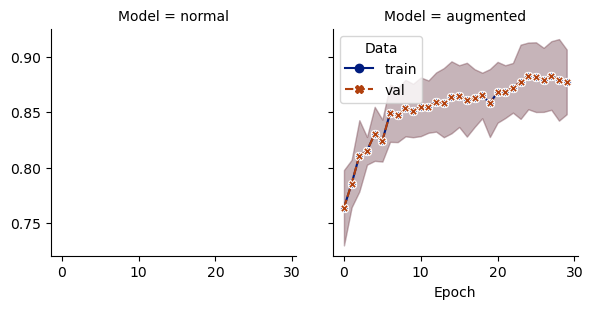

In [37]:
g = sns.FacetGrid(trainingPerf, col = "Model")
sns.lineplot(data = trainingPerf, x = "Epoch", y = "Acc",
                            palette = "dark", hue = "Data", style = "Data", markers = True)

# Evaluation des modèles en inférence et interprétabilité

In [32]:
def getSaliency(model, img, label, modelName):
    model.eval()
    #img = img.to(device)
    img.requires_grad = True
    img.grad = None
    outputs = nn.Softmax(dim=1)(model(img.unsqueeze(0)))
    _, predicted = torch.max(outputs.data, 1)
    output=outputs[0,label]
    output.backward()
    sal=img.grad.abs()
    if sal.dim()>2:
        sal=torch.max(sal,dim=0)[0]
    
    print(modelName, "\n True label :", label.item(), "Predicted label : ", predicted.item())
    fig=plt.figure(figsize=(8, 8))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img.detach().cpu().permute(1,2,0),cmap="gray")

    fig.add_subplot(1, 2, 2)
    plt.imshow(sal.to('cpu'),cmap="seismic",interpolation="bilinear")
    
    plt.show()

In [34]:
for combo in comboList:
    modName = combo[0]
    test = combo[4]
    
    model = models.resnet18()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4)
    state_dict = torch.load(modName + ".pt")
    model.load_state_dict(state_dict)
    
    perf = perf_eval(model, test, device)
    print("Performance in inference with the " + modName + " : ", perf)

Performance in inference with the normal :  0.6154276481450394
Performance in inference with the augmented :  0.5712136515397385


# interprétabilité des modèles

In [36]:
for combo in comboList:
    modName = combo[0]
    test = combo[4]
    
    model = models.resnet18()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    state_dict = torch.load(modName + ".pt")
    model.load_state_dict(state_dict)
    
    nb = 0
    while nb < 20:
        for inputs, labels in val:
            for i in range(len(labels)):
                getSaliency(model,inputs[i],labels[i], modelName)
                nb += 1
                if nb == 20:
                    break
            if nb == 20:
                break

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([4, 512]) from checkpoint, the shape in current model is torch.Size([2, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([2]).